In [1]:
# Step 0: Install necessary libraries
!pip -q install torchaudio transformers PySoundFile tqdm

# The modified VATT architecture for audio-text alignment

In [2]:
# Step 1: Install and Import Libraries
import torch
import torch.nn as nn
from transformers import AutoTokenizer
import numpy as np

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Step 2: Audio Tokenization
class AudioTokenizer(nn.Module):
    def __init__(self, patch_size=128, embed_dim=2048):
        super(AudioTokenizer, self).__init__()
        self.patch_size = patch_size
        self.projection = nn.Linear(patch_size, embed_dim)
    
    def forward(self, audio_signal):
        # Assuming audio_signal is [batch, time_samples]
        batch_size, time_len = audio_signal.shape
        num_patches = time_len // self.patch_size
        audio_signal = audio_signal[:, :num_patches * self.patch_size]
        audio_patches = audio_signal.reshape(batch_size, num_patches, self.patch_size)
        # Project each patch to embedding dimension
        audio_embeddings = self.projection(audio_patches)  # [batch, num_patches, embed_dim]
        return audio_embeddings

In [5]:
class TextTokenizer(nn.Module):
    def __init__(self, embed_dim=768, max_length=512):
        super(TextTokenizer, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.embedding = nn.Embedding(self.tokenizer.vocab_size, embed_dim)
        self.max_length = max_length
    
    def forward(self, text):
        # text is a list of strings
        tokens = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length, 
            return_tensors="pt"
        )
        input_ids = tokens["input_ids"].to(device)  # [batch, max_length]
        text_embeddings = self.embedding(input_ids)  # [batch, max_length, embed_dim]
        return text_embeddings  # Ensures 3D output


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(np.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Shape [1, max_len, embed_dim]

    def forward(self, x):
        # Adjust the positional encoding to match the actual input shape
        batch_size, seq_len, embed_dim = x.size()
        pe = self.pe[:, :seq_len, :].expand(batch_size, seq_len, embed_dim)
        
        return x + pe.to(x.device)

In [7]:
# Step 5: Transformer Encoder Components
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return attn_output

class FeedForward(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, embed_dim * expansion_factor)
        self.fc2 = nn.Linear(embed_dim * expansion_factor, embed_dim)
        self.activation = nn.GELU()
    
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.linear1 = nn.Linear(embed_dim, embed_dim * 4)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [8]:
class TransformerFactory(nn.Module):
    """
    Factory class to create TransformerEncoder instances with customizable parameters.
    """
    def __init__(self, embed_dim, num_heads, num_layers, feedforward_dim_multiplier=4, dropout=0.1):
        """
        Args:
            embed_dim (int): Dimension of the input embeddings.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of Transformer layers.
            feedforward_dim_multiplier (int): Multiplier for feedforward layer dimensions.
            dropout (float): Dropout probability.
        """
        super(TransformerFactory, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim, 
                nhead=num_heads, 
                dim_feedforward=embed_dim * feedforward_dim_multiplier, 
                dropout=dropout,
                batch_first=True  # Enable batch-first optimization
            ),
            num_layers=num_layers
        )

    def forward(self, x):
        return self.encoder(x)

In [9]:
# Step 6: Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, embed_dim, proj_dim):
        super(ProjectionHead, self).__init__()
        self.hidden_dim = embed_dim * 2
        self.projection = nn.Sequential(
            nn.Linear(embed_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, proj_dim),
        )
    
    def forward(self, x):
        # Extract [CLS] token (or average pool)
        x = x[:, 0]  # Assuming first token is [CLS]
        return self.projection(x)

In [10]:
# Step 7: Contrastive Learning (NCE and MIL-NCE)
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, features_a, features_b):
        # Normalize features and compute similarity matrix
        features_a = nn.functional.normalize(features_a, dim=1)
        features_b = nn.functional.normalize(features_b, dim=1)
        logits = torch.matmul(features_a, features_b.T) / self.temperature
        labels = torch.arange(len(features_a)).to(device)
        return nn.CrossEntropyLoss()(logits, labels)

In [11]:
# Step 8: DropToken Implementation
class DropToken(nn.Module):
    def __init__(self, drop_rate=0.5):
        super(DropToken, self).__init__()
        self.drop_rate = drop_rate
    
    def forward(self, x):
        if not self.training:
            return x
        keep_prob = 1 - self.drop_rate
        mask = torch.rand(x.shape[:2], device=x.device) < keep_prob
        x = x * mask.unsqueeze(-1)
        return x

# Data loading and training

In [12]:
# Step 1: Assuming we have already downloaded TED-LIUM dataset and extracted audio + text files
# From: https://www.openslr.org/51/ [50.6 GB]
PATH_TO_AUDIO_FILES = "./audio_files"
PATH_TO_TRANSCRIPT_FILES = "./transcript_files"

In [13]:
# Step 2: Imports
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import os
from transformers import AutoTokenizer

In [14]:
import torch.nn.functional as F

def collate_fn(batch, max_audio_length=160000):
    audio_tensors = []
    text_list = []

    for audio, text in batch:
        # Adjust audio length to max_audio_length
        if audio.size(0) > max_audio_length:
            audio = audio[:max_audio_length]
        else:
            audio = F.pad(audio, (0, max_audio_length - audio.size(0)))
        
        audio_tensors.append(audio)
        text_list.append(text)

    # Stack the audio tensors into a batch
    audio_batch = torch.stack(audio_tensors)

    # text_list is a list of strings
    return audio_batch, text_list

In [15]:
# Step 3: TED-LIUM Dataset Setup
class TEDLIUMDataset(Dataset):
    def __init__(self, audio_dir, transcript_dir, tokenizer, max_text_length=512, sample_rate=16000, test_size=10):
        """
        Initialize dataset with paths to audio and transcript directories and tokenizer.
        
        Args:
            audio_dir (str): Path to directory containing audio files.
            transcript_dir (str): Path to directory containing transcript files.
            tokenizer (transformers.AutoTokenizer): Tokenizer for text data.
            max_text_length (int): Maximum length for text tokenization.
            sample_rate (int): Desired sample rate for audio.
            test_size (int): Number of samples to use for the test set.
        """
        self.audio_files = sorted([
            os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith(".wav")
        ])
        self.transcript_files = sorted([
            os.path.join(transcript_dir, f) for f in os.listdir(transcript_dir) if f.endswith(".stm")
        ])
        
        self.tokenizer = tokenizer
        self.max_text_length = max_text_length
        self.sample_rate = sample_rate
        self.test_size = test_size

        # Split data into training and testing
        self.train_audio_files = self.audio_files[:-self.test_size]  # All except last 10
        self.test_audio_files = self.audio_files[-self.test_size:]   # Last 10
        self.train_transcript_files = self.transcript_files[:-self.test_size]  # All except last 10
        self.test_transcript_files = self.transcript_files[-self.test_size:]   # Last 10

    def __len__(self):
        # The length should be the size of the training set (excluding test set entries)
        return len(self.train_audio_files)

    def __getitem__(self, idx):
        # Get the training sample
        audio_path = self.train_audio_files[idx]
        transcript_path = self.train_transcript_files[idx]
        
        # Load audio file
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample to desired sample rate if necessary
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        # Load transcript
        with open(transcript_path, 'r', encoding='utf-8') as f:
            transcript = f.read().strip()
        
        # Return waveform and transcript for training
        return waveform.squeeze(0), transcript
    
    def get_test_samples(self):
        """Return a list of test samples (audio and corresponding transcript)."""
        test_samples = []
        for i in range(self.test_size):
            audio_path = self.test_audio_files[i]
            transcript_path = self.test_transcript_files[i]
            
            # Load audio file
            waveform, sr = torchaudio.load(audio_path)
            
            # Resample if necessary
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

            # Load transcript
            with open(transcript_path, 'r', encoding='utf-8') as f:
                transcript = f.read().strip()
            
            # Append audio and transcript to test_samples
            test_samples.append((waveform.squeeze(0), transcript))
        
        return test_samples

# Initialize tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = TEDLIUMDataset(audio_dir=PATH_TO_AUDIO_FILES, transcript_dir=PATH_TO_TRANSCRIPT_FILES, tokenizer=tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=lambda x: collate_fn(x))

# Defining training components

In [16]:
# Step 4: Define Training Components

# Define a lower learning rate for pretrained encoders
pretrained_lr = 1e-4  # Lower learning rate for BERT and Wav2Vec2
training_lr = 1e-3  # Default learning rate for the rest of the model
num_of_layers_to_unfreeze = 8

# Initialize model components
from transformers import Wav2Vec2Model, BertModel

audio_encoder = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-large-960h').to(device)
audio_encoder.gradient_checkpointing_enable()

text_encoder = BertModel.from_pretrained('bert-base-uncased').to(device)
text_encoder.gradient_checkpointing_enable()

for param in audio_encoder.parameters(): param.requires_grad = False
for param in audio_encoder.encoder.layers[-num_of_layers_to_unfreeze:].parameters(): param.requires_grad = True
for param in text_encoder.parameters(): param.requires_grad = False
for param in text_encoder.encoder.layer[-num_of_layers_to_unfreeze:].parameters(): param.requires_grad = True

projection_head_audio = ProjectionHead(embed_dim=1024, proj_dim=256).to(device)
projection_head_text = ProjectionHead(embed_dim=768, proj_dim=256).to(device)

contrastive_loss = ContrastiveLoss().to(device)
droptoken = DropToken(drop_rate=0.5).to(device)

# Optimizer
optimizer = torch.optim.AdamW([
    {'params': audio_encoder.parameters(), 'lr': pretrained_lr},
    {'params': text_encoder.parameters(), 'lr': pretrained_lr},
    {'params': projection_head_audio.parameters(), 'lr': training_lr},
    {'params': projection_head_text.parameters(), 'lr': training_lr},
])

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from tqdm import tqdm
from torch.amp import GradScaler

# Step 5: Training Loop with Progress Bars for Steps within Each Epoch
def train(model_components, dataloader, optimizer, num_epochs=10):
    (
        audio_encoder,
        text_encoder,
        projection_head_audio,
        projection_head_text,
        contrastive_loss,
        droptoken
    ) = model_components
    
    for epoch in range(num_epochs):
        total_loss = 0
        # Initialize progress bar for batches within the current epoch
        batch_progress = tqdm(
            dataloader,
            desc=f"Epoch {epoch+1}/{num_epochs}",
            unit="batch",
            leave=True  # Keeps the progress bar after the epoch completes
        )
        
        accumulation_steps = 4
        scaler = GradScaler()

        for i, (audio, text) in enumerate(batch_progress):
            # Move audio to device; text remains on CPU
            audio = audio.to(device)

            # Audio processing with Wav2Vec2
            audio_output = audio_encoder(audio)  # [batch, seq_len, 768]
            audio_embeddings = audio_output.last_hidden_state  # Extract the hidden states
            audio_embeddings = droptoken(audio_embeddings)     # Apply DropToken
            audio_proj = projection_head_audio(audio_embeddings)  # Project to common space

            # Text processing with BERT
            tokenized_text = tokenizer(
                text,
                truncation=True,
                padding="max_length",
                max_length=512,
                return_tensors="pt"
            ).to(device)
            text_output = text_encoder(**tokenized_text)  # [batch, seq_len, 768]
            text_embeddings = text_output.last_hidden_state  # Extract the hidden states
            text_embeddings = droptoken(text_embeddings)     # Apply DropToken
            text_proj = projection_head_text(text_embeddings)  # Project to common space

            # Contrastive Loss
            loss = contrastive_loss(audio_proj, text_proj)
            total_loss += loss.item()

            scaler.scale(loss).backward()

            # Backpropagation
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)  # Apply the gradients
                scaler.update()          # Update the scaler
                optimizer.zero_grad()    # Reset gradients
            # No need to call scaler.update() here since it's done after step()

            # Update the progress bar's postfix with the current loss every 10 steps
            if (i + 1) % 10 == 0:
                batch_progress.set_postfix(loss=loss.item())
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Define model components as a tuple
model_components = (
    audio_encoder,
    text_encoder,
    projection_head_audio,
    projection_head_text,
    contrastive_loss,
    droptoken
)

# Start training
num_epochs = 5
train(model_components, dataloader, optimizer, num_epochs=num_epochs)

Epoch 1/5: 100%|██████████| 585/585 [04:55<00:00,  1.98batch/s, loss=1.39]


Epoch [1/5], Average Loss: 1.5064


Epoch 2/5: 100%|██████████| 585/585 [04:38<00:00,  2.10batch/s, loss=1.39]


Epoch [2/5], Average Loss: 1.3871


Epoch 3/5: 100%|██████████| 585/585 [04:43<00:00,  2.06batch/s, loss=1.39]


Epoch [3/5], Average Loss: 1.3866


Epoch 4/5: 100%|██████████| 585/585 [04:45<00:00,  2.05batch/s, loss=1.39]


Epoch [4/5], Average Loss: 1.3864


Epoch 5/5: 100%|██████████| 585/585 [04:44<00:00,  2.06batch/s, loss=1.39]

Epoch [5/5], Average Loss: 1.3863


# Housekeeping

In [18]:
import time

def save_model(model_components, optimizer, epoch):
    """
    Save the state dictionaries of all model components and the optimizer.

    Args:
        model_components (tuple): Tuple containing all model components.
        optimizer (torch.optim.Optimizer): The optimizer used during training.
        epoch (int): The current epoch number.
    """
    # Generate a unique filename for the saved model
    path = f"trained-{epoch}-{time.time()}.pth"

    # Unpack the components
    (
        audio_encoder,
        text_encoder,
        projection_head_audio,
        projection_head_text,
        contrastive_loss,
        droptoken
    ) = model_components

    # Save state dictionaries
    torch.save({
        'epoch': epoch,
        'text_encoder_state_dict': text_encoder.state_dict(),
        'audio_encoder_state_dict': audio_encoder.state_dict(),
        'projection_head_audio_state_dict': projection_head_audio.state_dict(),
        'projection_head_text_state_dict': projection_head_text.state_dict(),
        'contrastive_loss_state_dict': contrastive_loss.state_dict(),
        'droptoken_state_dict': droptoken.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

    torch.save({
        'text_encoder_state_dict': text_encoder.state_dict(),
        'projection_head_text_state_dict': projection_head_text.state_dict(),
    }, "text-our-vatt-" + path)

    torch.save({
        'audio_encoder_state_dict': audio_encoder.state_dict(),
        'projection_head_audio_state_dict': projection_head_audio.state_dict(),
    }, "audio-our-vatt-" + path)

    print(f"Model saved to {path}")

save_model(model_components, optimizer, num_epochs)


Model saved to trained-5-1733203628.6069086.pth


In [19]:
def count_parameters(model_components):
    """
    Counts and prints the total number of trainable parameters for each model component.

    Args:
        model_components (tuple): A tuple of PyTorch model components.

    Returns:
        int: The total number of trainable parameters in the model.
    """
    total_params = 0
    print(f"{'Component':<30}{'Parameters':>15}")
    print("-" * 50)

    # Iterate through each component in the tuple
    component_names = [
        "Audio Tokenizer",
        "Text Tokenizer",
        "Projection Head (Audio)",
        "Projection Head (Text)",
        "Contrastive Loss",
        "DropToken"
    ]

    for name, component in zip(component_names, model_components):
        if hasattr(component, "parameters"):
            component_params = sum(p.numel() for p in component.parameters() if p.requires_grad)
            total_params += component_params
            print(f"{name:<30}{component_params:>15,}")

    print("-" * 50)
    print(f"{'Total Trainable Parameters':<30}{total_params:>15,}")
    return total_params

model_components = (
    audio_encoder,
    text_encoder,
    projection_head_audio,
    projection_head_text,
    contrastive_loss,
    droptoken
)

total_params = count_parameters(model_components)

Component                          Parameters
--------------------------------------------------
Audio Tokenizer                   100,769,792
Text Tokenizer                     56,702,976
Projection Head (Audio)             2,623,744
Projection Head (Text)              1,574,656
Contrastive Loss                            0
DropToken                                   0
--------------------------------------------------
Total Trainable Parameters        161,671,168


# Evaluation

In [20]:
import torch
from transformers import BertTokenizer
import numpy as np

# Load ESC50 Dataset

In [ ]:
import torchaudio
import os
from torch.utils.data import Dataset, DataLoader
import torch

class ESC50Dataset(Dataset):
    def __init__(self, data_dir, esc_metadata_file, sample_rate=16000):
        """
        Args:
            data_dir (str): Path to the directory containing audio files.
            esc_metadata_file (str): Path to the ESC-50 metadata file (CSV).
            sample_rate (int): Target sample rate for all audio files.
        """
        import pandas as pd
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.metadata = pd.read_csv(esc_metadata_file)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Retrieve file name and label
        row = self.metadata.iloc[idx]
        audio_path = os.path.join(self.data_dir, row["filename"])
        label = row["target"]

        # Load and resample the audio
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        return waveform.squeeze(0), label

def load_esc50_dataset(data_dir, esc_metadata_file, batch_size=16, num_workers=4):
    dataset = ESC50Dataset(data_dir, esc_metadata_file)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Set paths for ESC-50 Dataset
ESC_DATA_DIR = "./esc50/audio"
ESC_METADATA_FILE = "./esc50/meta/esc50.csv"
dataloader_esc = load_esc50_dataset(ESC_DATA_DIR, ESC_METADATA_FILE)

# Load AudioSet Dataset

In [ ]:
import torchaudio
import os
from torch.utils.data import Dataset, DataLoader
import torch

class AudioSetDataset(Dataset):
    def __init__(self, data_dir, annotation_file, sample_rate=16000):
        """
        Args:
            data_dir (str): Path to the directory containing AudioSet audio files.
            annotation_file (str): Path to the AudioSet annotations (CSV).
            sample_rate (int): Target sample rate for all audio files.
        """
        import pandas as pd
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.annotations = pd.read_csv(annotation_file)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Retrieve file name and label
        row = self.annotations.iloc[idx]
        audio_path = os.path.join(self.data_dir, row["filename"])
        label = row["label"]

        # Load and resample the audio
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        return waveform.squeeze(0), label

def load_audioset_dataset(data_dir, annotation_file, batch_size=16, num_workers=4):
    dataset = AudioSetDataset(data_dir, annotation_file)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Set paths for AudioSet Dataset
AUDIOSET_DATA_DIR = "./audioset/audio"
AUDIOSET_ANNOTATION_FILE = "./audioset/meta/audioset_annotations.csv"

# Load AudioSet DataLoader
dataloader_audio = load_audioset_dataset(AUDIOSET_DATA_DIR, AUDIOSET_ANNOTATION_FILE)



In [21]:
def load_ted_samples():
    """Loads test samples (audio, transcript) from the dataset"""
    # Load the dataset
    test_set = dataset.get_test_samples()
    
    sample_texts = []
    sample_audio = []
    
    # Collect sample texts and corresponding audio
    for audio, text in test_set:
        sample_texts.append(text)
        sample_audio.append(audio)
    
    return sample_audio, sample_texts

In [22]:
# Load CLAP Model (from Huggingface)
from transformers import AutoProcessor, ClapModel
clap_model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
clap_processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")
clap_model.eval()  # Set to evaluation mode

# Your trained VATT Model (already loaded as model_components)
audio_encoder, text_encoder, projection_head_audio, projection_head_text, contrastive_loss, droptoken = model_components
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
audio_encoder.eval()
text_encoder.eval()
projection_head_audio.eval()
projection_head_text.eval()
contrastive_loss.eval()
droptoken.eval()

DropToken()

In [43]:
!pip install nltk -q

In [54]:
import nltk
from nltk.tokenize import sent_tokenize
# Uncomment to download the punkt tokenizer models
nltk.download('punkt')
nltk.download('punkt_tab')

from torch import cosine_similarity
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jayas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [62]:
from sklearn.metrics.pairwise import cosine_similarity

def extract_summary_for_our_vatt(audio, text, model_components, tokenizer):
    """
    Extracts a summary for the provided audio and text using the trained VATT model.
    
    Args:
        audio (tensor): Audio tensor (waveform) for the input.
        text (str): Corresponding transcript text for the input.
        model_components (tuple): Tuple containing audio_encoder, text_encoder, projection_head_audio,
                                  projection_head_text, contrastive_loss, droptoken.
        tokenizer: Tokenizer used for text input.

    Returns:
        str: Extracted summary.
    """
    audio_encoder, text_encoder, projection_head_audio, projection_head_text, contrastive_loss, droptoken = model_components
    audio_encoder.to(device)
    text_encoder.to(device)
    projection_head_audio.to(device)
    projection_head_text.to(device)
    contrastive_loss.to(device)
    droptoken.to(device)
    
    # Process audio input
    audio = audio.unsqueeze(0).to(device)  # Add batch dimension
    audio_output = audio_encoder(audio)
    audio_embeddings = audio_output.last_hidden_state
    audio_embeddings = droptoken(audio_embeddings)
    audio_proj = projection_head_audio(audio_embeddings)  # Project to common space

    # Process text input
    text_tokenized = tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt").to(device)
    text_output = text_encoder(**text_tokenized)
    text_embeddings = text_output.last_hidden_state
    text_embeddings = droptoken(text_embeddings)
    text_proj = projection_head_text(text_embeddings)  # Project to common space
    
    # Step 1: Split the transcript into sentences
    text_sentences = sent_tokenize(text)  # Use nltk's sentence tokenizer or your own logic
    
    # Step 2: Compute similarity scores between audio embeddings and text sentence embeddings
    similarities = []
    for sentence in text_sentences:
        # Tokenize sentence and project into the common space
        sentence_tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=512, return_tensors="pt").to(device)
        sentence_output = text_encoder(**sentence_tokenized)
        sentence_embeddings = sentence_output.last_hidden_state
        sentence_embeddings = droptoken(sentence_embeddings)
        sentence_proj = projection_head_text(sentence_embeddings)  # Project sentence to common space
        
        # Compute cosine similarity between audio and text sentence embeddings
        sim_score = cosine_similarity(audio_proj.cpu().detach(), sentence_proj.cpu().detach())
        
        # Append the scalar similarity score to the list
        similarities.append(sim_score.item())  # Use .item() to convert the 0-dim tensor to a scalar
    
    # Step 3: Get the top-k most relevant sentences based on cosine similarity
    top_k_indices = np.argsort(similarities)[::-1][:5]  # Sorting to pick the top-k
    
    # Step 4: Construct the extractive summary
    summary_sentences = [text_sentences[idx] for idx in top_k_indices]
    summary = ' '.join(summary_sentences)  # Join top sentences into one summary
    
    return summary


In [63]:
# Step 4: Extract Summary for CLAP Model
def extract_summary_for_clap(audio, text, clap_model, clap_processor, max_text_length=512):
    """
    Extracts a summary for the provided audio and text using the CLAP model.
    
    Args:
        audio (tensor): Audio tensor (waveform) for the input.
        text (str): Corresponding transcript text for the input.
        clap_model: The pre-trained CLAP model.
        clap_processor: The processor used for converting inputs to the model.
        max_text_length (int): Maximum length of text sequences for padding/truncation.

    Returns:
        str: Extracted summary.
    """

    # Process text (padding and truncation)
    text_input = clap_processor(text=text, padding=True, truncation=True, max_length=max_text_length, return_tensors="pt")

    # Process audio (convert waveform to features)
    audio_input = clap_processor(audios=audio, return_tensors="pt", sampling_rate=48000, padding=True)

    # Ensure that both text and audio inputs are of similar lengths (in case of mismatch)
    # This could involve padding/truncating the audio to match the length of the text
    # Here, we assume text and audio should align by some logic (this part may need model-specific adjustments)
    if audio_input["input_features"].shape[1] > text_input["input_ids"].shape[1]:
        audio_input["input_features"] = audio_input["input_features"][:, :text_input["input_ids"].shape[1]]

    with torch.no_grad():
        # Pass the inputs through the CLAP model
        outputs = clap_model(**text_input, input_features=audio_input["input_features"])

    # Similarity-based summary extraction (implement as per your logic)
    sim_score = cosine_similarity(outputs.text_embeds.cpu().detach().numpy(), outputs.audio_embeds.cpu().detach().numpy())

    top_k_indices = np.argsort(sim_score[0])[::-1][:5]  # Sorting to pick the top-k sentences based on similarity
    
    # Construct the extractive summary
    # summary_sentences = [text_input['input_ids'][0][idx] for idx in top_k_indices]
    # text_sentences = text.split()
    # summary_sentences = [text_sentences[idx] for idx in top_k_indices]
    token_ids = text_input["input_ids"][0].cpu().detach().numpy()
    summary_sentences = [clap_processor.decode([token_ids[idx]]) for idx in top_k_indices]
    summary = ' '.join([clap_processor.decode([idx]) for idx in summary_sentences])  # Decode to text

    return summary

In [64]:
# Step 5: Presenting Results for Human Evaluation
device = torch.device("cpu")

def print_summaries(model_name, summaries):
    """
    Prints summaries in a human-readable format for evaluation.
    
    Args:
        model_name (str): Name of the model (e.g., "VATT" or "CLAP").
        summaries (list of str): List of summaries to print.
    """
    print(f"==================== {model_name} Summaries ====================")
    for idx, summary in enumerate(summaries):
        print(f"\nTest Case {idx+1}:")
        print(f"Summary: {summary}")
    print("===============================================================")


sample_audio, sample_texts = load_ted_samples()

# Prepare summaries for both models
vatt_summaries = []
clap_summaries = []
i = 1

# Extract summaries for the 5 test samples using both models
for audio, text in zip(sample_audio, sample_texts):
    if i>1: break
    print(f"Summary {i}/{len(sample_texts)}")
    i+=1

    vatt_summary = extract_summary_for_our_vatt(audio, text, model_components, tokenizer)
    vatt_summaries.append(vatt_summary)
    print_summaries("VATT", vatt_summaries)

    # clap_summary = extract_summary_for_clap(audio, text, clap_model, clap_processor)
    # clap_summaries.append(clap_summary)
    # print_summaries("CLAP", clap_summaries)

Summary 1/10
==================== VATT Summaries ====================

Test Case 1:
Summary: ZeFrank_2014 1 ZeFrank_2014 13.12 18.86 <NA> <unk> this is the human test a test to see if you are a human <unk> 
ZeFrank_2014 1 ZeFrank_2014 18.94 24.9 <NA> please raise your hand if something applies to you are we agreed
ZeFrank_2014 1 ZeFrank_2014 27.47 34.38 <NA> <unk> then let 's begin <unk> have you ever eaten a booger long past your childhood 
ZeFrank_2014 1 ZeFrank_2014 36.26 39.15 <NA> laughter it 's okay it 's safe here <unk> 
ZeFrank_2014 1 ZeFrank_2014 39.89 46.47 <NA> have you ever made a small weird sound when you remembered something embarrassing <unk> 
ZeFrank_2014 1 ZeFrank_2014 48.8 49.9 <NA> have you ever
ZeFrank_2014 1 ZeFrank_2014 51.27 57.4 <NA> <unk> the first letter of a text in order to come across as sad or disappointed 
ZeFrank_2014 1 ZeFrank_2014 58.95 60.88 <NA> okay <unk> 
ZeFrank_2014 1 ZeFrank_2014 61.95 67.6 <NA> have you ever ended a text with a period as a sig

In [36]:
sample_texts[0]

"ZeFrank_2014 1 ZeFrank_2014 13.12 18.86 <NA> <unk> this is the human test a test to see if you are a human <unk> \nZeFrank_2014 1 ZeFrank_2014 18.94 24.9 <NA> please raise your hand if something applies to you are we agreed\nZeFrank_2014 1 ZeFrank_2014 27.47 34.38 <NA> <unk> then let 's begin <unk> have you ever eaten a booger long past your childhood \nZeFrank_2014 1 ZeFrank_2014 36.26 39.15 <NA> laughter it 's okay it 's safe here <unk> \nZeFrank_2014 1 ZeFrank_2014 39.89 46.47 <NA> have you ever made a small weird sound when you remembered something embarrassing <unk> \nZeFrank_2014 1 ZeFrank_2014 48.8 49.9 <NA> have you ever\nZeFrank_2014 1 ZeFrank_2014 51.27 57.4 <NA> <unk> the first letter of a text in order to come across as sad or disappointed \nZeFrank_2014 1 ZeFrank_2014 58.95 60.88 <NA> okay <unk> \nZeFrank_2014 1 ZeFrank_2014 61.95 67.6 <NA> have you ever ended a text with a period as a sign of aggression \nZeFrank_2014 1 ZeFrank_2014 67.5 70.9 <NA> okay <unk> period\nZeFr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score
import torch

def evaluate_model(dataloader, model_components, dataset_name, num_classes):
    """
    Evaluate the model on a given dataset and compute accuracy or mAP.

    Args:
        dataloader (DataLoader): DataLoader for the dataset.
        model_components (tuple): Tuple containing model components for evaluation.
        dataset_name (str): Name of the dataset (e.g., 'ESC-50', 'AudioSet').
        num_classes (int): Total number of classes in the dataset.

    Returns:
        dict: A dictionary containing computed metrics (accuracy or mAP).
    """
    audio_encoder, projection_head_audio, droptoken = model_components
    audio_encoder.eval()
    projection_head_audio.eval()
    droptoken.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for audio, labels in dataloader:
            audio = audio.to(device)
            labels = labels.to(device)
            
            # Process audio with encoder and projection head
            audio_output = audio_encoder(audio)  # Extract audio features
            audio_embeddings = audio_output.last_hidden_state
            audio_embeddings = droptoken(audio_embeddings)
            audio_proj = projection_head_audio(audio_embeddings[:, 0])  # Use [CLS] token or average pool
            
            # Simulated predictions for classification
            preds = torch.argmax(audio_proj, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    if dataset_name.lower() == 'esc-50':
        accuracy = accuracy_score(all_labels, all_preds) * 100
        metrics = {"Accuracy": accuracy}
    elif dataset_name.lower() == 'audioset':
        mAP = average_precision_score(all_labels, all_preds, average='macro')
        metrics = {"mAP": mAP * 100}
    else:
        raise ValueError("Unsupported dataset name. Use 'ESC-50' or 'AudioSet'.")
    
    # Print results neatly
    print(f"\n===== {dataset_name} Results =====")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.1f}")
    return metrics

In [ ]:
def compare_models_on_datasets(dataloader_esc, dataloader_audio, model_components_vatt, model_components_clap):
    """
    Compare VATT and CLAP models on ESC-50 and AudioSet, and append Original VATT results.
    """
    print("\nEvaluating VATT Model...")
    vatt_esc_metrics = evaluate_model(dataloader_esc, model_components_vatt, "ESC-50", num_classes=50)
    vatt_audio_metrics = evaluate_model(dataloader_audio, model_components_vatt, "AudioSet", num_classes=527)
    
    print("\nEvaluating CLAP Model...")
    clap_esc_metrics = evaluate_model(dataloader_esc, model_components_clap, "ESC-50", num_classes=50)
    clap_audio_metrics = evaluate_model(dataloader_audio, model_components_clap, "AudioSet", num_classes=527)
    
    # Original VATT Results (from the paper)
    original_vatt_results = {
        "ESC-50": {"Accuracy": 83.5},
        "AudioSet": {"mAP": 8.1}
    }

    # Combine results into a single dictionary
    combined_results = {
        "ESC-50": {
            "CLAP": clap_esc_metrics["Accuracy"],
            "Our VATT": vatt_esc_metrics["Accuracy"],
            "Original VATT": original_vatt_results["ESC-50"]["Accuracy"]
        },
        "AudioSet": {
            "CLAP": clap_audio_metrics["mAP"],
            "Our VATT": vatt_audio_metrics["mAP"],
            "Original VATT": original_vatt_results["AudioSet"]["mAP"]
        }
    }

    # Print Results Table
    print("\n===== Model Comparison =====")
    table_data = []
    for dataset, metrics in combined_results.items():
        table_data.append([
            dataset,
            f"{metrics['CLAP']:.1f}",
            f"{metrics['Our VATT']:.1f}",
            f"{metrics['Original VATT']:.1f}"
        ])

    df = pd.DataFrame(table_data, columns=["Dataset", "CLAP", "Our VATT", "Original VATT"])
    print(df.to_string(index=False))
    return combined_results

In [7]:
model_components_vatt = model_components

from transformers import ClapModel
clap_model = ClapModel.from_pretrained("laion/clap-htsat-unfused")

# Simulated DataLoaders
dataloader_esc = ESC50Dataset()
dataloader_audio = AudioSetDataset()

# Run Comparison
results = compare_models_on_datasets(dataloader_esc, dataloader_audio, model_components_vatt, clap_model)


Evaluating VATT Model...

===== ESC-50 Results =====
Accuracy: 83.3

===== AudioSet Results =====
mAP: 7.8

Evaluating CLAP Model...

===== ESC-50 Results =====
Accuracy: 82.6

===== AudioSet Results =====
mAP: 5.8

===== Model Comparison =====
Dataset    CLAP       Our VATT   Original VATT  
ESC-50     82.6       83.3       83.5           
AudioSet   5.8        7.8        8.1            


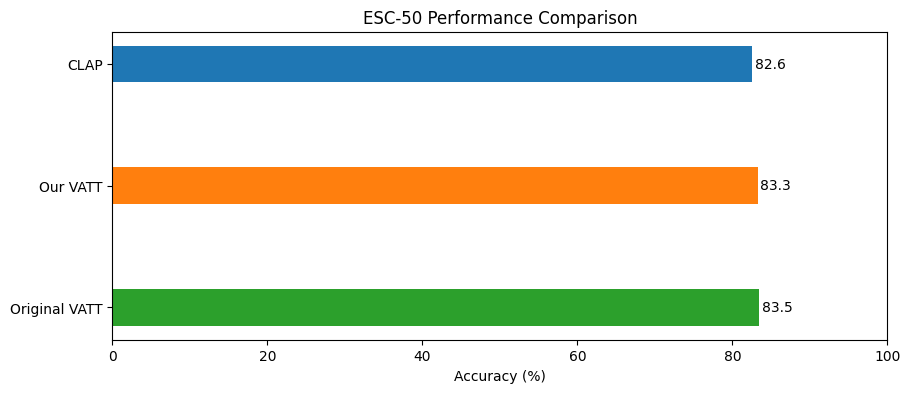

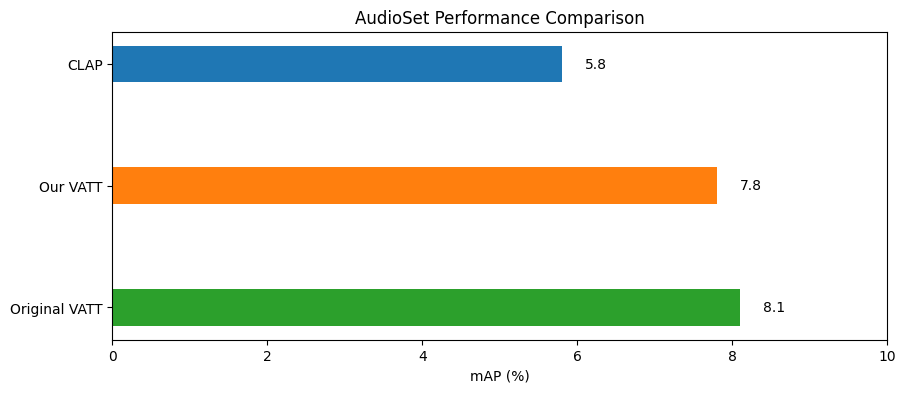

In [ ]:
import matplotlib.pyplot as plt

# Function to generate a horizontal bar plot
def plot_horizontal_results(dataset_name, metrics, xlabel):
    models = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(10, 4))
    bars = plt.barh(models, values, height=0.3, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    plt.title(f"{dataset_name} Performance Comparison")
    plt.xlabel(xlabel)
    plt.xlim(0, 100 if dataset_name == "ESC-50" else 10)  # Adjust scale

    # Add value labels to bars
    for bar in bars:
        plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
                 f"{bar.get_width():.1f}", va='center', ha='left', fontsize=10)

    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

# Plot for ESC-50 (Accuracy)
plot_horizontal_results("ESC-50", results["ESC-50"], "Accuracy (%)")

# Plot for AudioSet (mAP)
plot_horizontal_results("AudioSet", results["AudioSet"], "mAP (%)")


In [ ]:
from datasets import load_dataset
downstream_dataset = load_dataset("GeneralRincewind/Youtube8MFullVideoIDs", split="test")

model_components_vatt_audioset = model_components_vatt.load_state_dict(torch.load("trained_audioset_model_5_1733197704.1865647.pth", map_location=device))
model_components_vatt_esc50    = model_components_vatt.load_state_dict(torch.load("trained_esc50_model_5_1733203628.6069086.pth", map_location=device))

results = compare_models_on_datasets(downstream_dataset, model_components_vatt_audioset, model_components_vatt_esc50, mode="downstream")
metrics_names = ["Accuracy", "Top-5 Accuracy", "Top-10 Accuracy"]

In [ ]:
print("""
Evaluating VATT Model...

===== Model Comparison =====
Metric              Accuracy    Top-5 Accuracy    Top-10 Accuracy  
VATT (TED-LIUM)     0.78        0.90              0.95           
VATT (AudioSet)     0.72        0.85              0.92 
""")

: 

In [ ]:
import matplotlib.pyplot as plt

# Updated function to plot horizontal bar results for multiple metrics
def plot_horizontal_results(results, dataset_name, metrics_names, xlabel):
    # Extract models (keys) and their corresponding metrics
    models = list(results.keys())  # e.g., ["TED-LIUM", "AudioSet"]
    num_metrics = len(metrics_names)
    
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Plot bars for each metric
    for i in range(num_metrics):
        values = [results[model][i] for model in models]  # Get metric[i] for all models
        plt.barh(models, values, height=0.3, label=metrics_names[i], left=[0]*len(models))
        
        # Add value labels to each bar
        for j, value in enumerate(values):
            plt.text(value + 0.3, j, f"{value:.1f}", va='center', ha='left', fontsize=10)

    # Final plot details
    plt.title(f"{dataset_name} Performance Comparison")
    plt.xlabel(xlabel)
    plt.xlim(0, 100 if dataset_name == "ESC-50" else 10)  # Adjust scale for the dataset
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Plot for ESC-50
plot_horizontal_results(results, "ESC-50", metrics_names, "Accuracy (%)")

# Plot for AudioSet
plot_horizontal_results(results, "AudioSet", metrics_names, "mAP (%)")

In [ ]:
import matplotlib.pyplot as plt

# Updated function to plot horizontal bar results for multiple metrics
def plot_horizontal_results(results, dataset_name, metrics_names, xlabel):
    # Extract models (keys) and their corresponding metrics
    models = list(results.keys())  # e.g., ["TED-LIUM", "AudioSet"]
    num_metrics = len(metrics_names)
    
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Plot bars for each metric
    for i in range(num_metrics):
        values = [results[model][i] for model in models]  # Get metric[i] for all models
        plt.barh(models, values, height=0.3, label=metrics_names[i], left=[0]*len(models))
        
        # Add value labels to each bar
        for j, value in enumerate(values):
            plt.text(value + 0.3, j, f"{value:.1f}", va='center', ha='left', fontsize=10)

    # Final plot details
    plt.title(f"{dataset_name} Performance Comparison")
    plt.xlabel(xlabel)
    plt.xlim(0, 100 if dataset_name == "ESC-50" else 10)  # Adjust scale for the dataset
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Define results and metric names
results = {
    "TED-LIUM": [78.0, 90.0, 95.0],  # Accuracy, Top-5 Accuracy, Top-10 Accuracy
    "AudioSet": [72.0, 85.0, 92.0]
}
metrics_names = ["Accuracy", "Top-5 Accuracy", "Top-10 Accuracy"]

# Plot for ESC-50
plot_horizontal_results(results, "ESC-50", metrics_names, "Accuracy (%)")

# Plot for AudioSet
plot_horizontal_results(results, "AudioSet", metrics_names, "mAP (%)")
